In [1]:
from pathlib import Path
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from skimage.measure import regionprops
import jax
import anndata as ad
from sklearn.metrics import PrecisionRecallDisplay

name = "E14.5_E1S3_labeled"
pred_dir = Path("mosta_prediction/")
sc_pred_file = "mosta_sc_prediction/E14.5_E1S3_SC.h5ad"
h5file = f"sg_data/E14.5_E1S3_labeled.h5"

## Read data

 - Read the segmentation label
 - Read predicted labels
 - remapping label ids so that the cell types are sorted by name

In [2]:
from skimage.transform import rescale
import h5py

# segmentation label

with h5py.File(h5file) as f:
    seg = f["segmentation"][...]
seg = seg[::4, ::4]

In [3]:
# chioso predictions

cell_type_dict = eval(open("ref_data/tome_cell_types").read())

cls_pred_file = pred_dir/f"{name}_label.tif"
score_file = pred_dir/f"{name}_score.tif"

mapping_r = [cell_type_dict[k] for k in sorted(cell_type_dict)]
mapping = np.argsort(mapping_r)

pred = tifffile.imread(cls_pred_file)
pred = mapping[pred]

score_map = tifffile.imread(score_file) # also read disciminator logits

pred_cls = np.zeros([seg.max()], "uint8") - 1
pred_scores = np.zeros([seg.max()])
for rp in regionprops(seg):
    co = rp["coords"]

    # the prediction may not be all same within the segmentation
    # use the most 'voted' prediction
    cls = np.argmax(np.bincount(pred[co[:,0], co[:,1]]))
    pred_cls[rp["label"]-1] = cls

    # use the mean dscriminator logits as the prediction score
    score = score_map[co[:, 0], co[:, 1]].mean()
    pred_scores[rp["label"]-1] = score

pred_label=np.r_[0, np.array(pred_cls)+1][seg]

In [4]:
# tacco predictions

anndata = ad.read_h5ad(sc_pred_file)

tacco_prob = np.array(anndata.obsm["OT"])
tacco_cls = tacco_prob.argmax(axis=1)
tacco_score = tacco_prob.max(axis=1)

tacco_label = np.r_[0, tacco_cls+1][seg]


# RCTD predictions

rctd_df = anndata.obsm["rctd"]
rctd_cls = np.array(rctd_df["first_type"])

rctd_score = rctd_df["min_score"]
# rctd_score = np.where(rctd_df["spot_class"]=="reject", -1, rctd_score)
rctd_label = np.r_[0, rctd_cls+1][seg]


# nn prediction
nn_logits = np.array(anndata.obsm["nn"])
nn_cls = nn_logits.argmax(axis=-1) # prediction
nn_prob = jax.nn.softmax(nn_logits) # prob of the each cell type
nn_scores = np.max(nn_prob, axis=-1)
nn_scores = np.where(np.isnan(nn_scores), 0, nn_scores)

# map the predictions back to segmentation images
nn_label = np.r_[0, nn_cls+1][seg]

2024-06-02 16:40:03.369790: W external/xla/xla/service/gpu/nvptx_compiler.cc:744] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


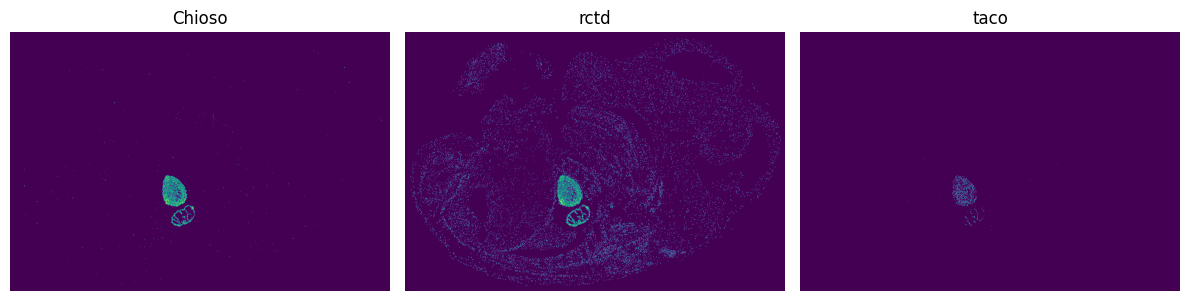

In [5]:
# visualize

fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(pred_label == 8)
ax[0].set_title("Chioso")
ax[1].imshow(rctd_label == 8)
ax[1].set_title("rctd")
ax[2].imshow(tacco_label == 8)
ax[2].set_title("tacco")
[a.axis('off') for a in ax]
plt.tight_layout()

## Comparing Chioso prediction with predictions from single-cell segmentation 

In [6]:
preds = [pred_cls, tacco_cls, rctd_cls, nn_cls]
m = np.zeros([4, 4])
for i, c1 in enumerate(preds):
    for j, c2 in enumerate(preds):
        m[i,j] = np.count_nonzero(c1 == c2) / len(c1)
print(m) 

[[1.         0.30648484 0.16353009 0.25961195]
 [0.30648484 1.         0.13296977 0.18349502]
 [0.16353009 0.13296977 1.         0.11529322]
 [0.25961195 0.18349502 0.11529322 1.        ]]


In [7]:
reject_rate = np.count_nonzero((rctd_df["spot_class"] == "reject") & (rctd_df["first_class"] >= 0))
reject_rate /= np.count_nonzero(rctd_df["first_class"] >= 0)
print(f"RCTD rejection rate : {reject_rate}")

RCTD rejection rate : 0.6405935567248223


#### Compute some metrics

Text(0.5, 1.0, 'Compare with TACO')

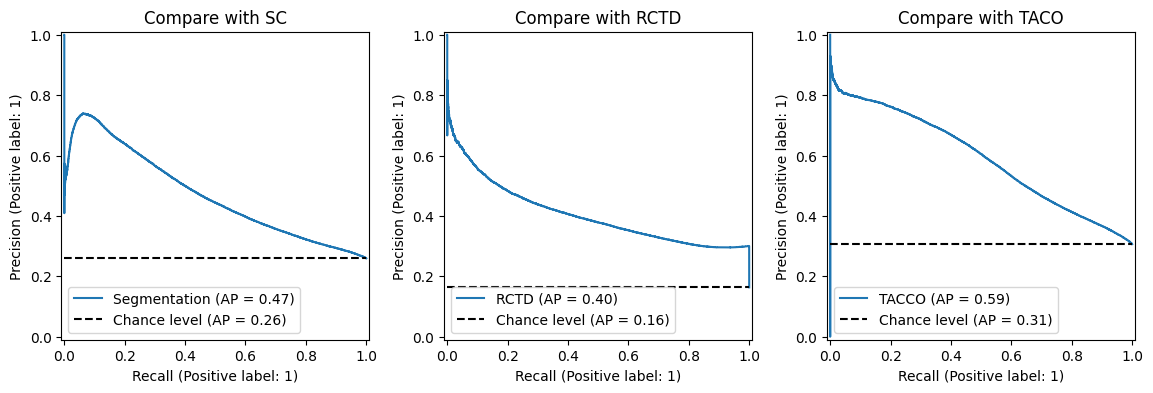

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(14,4))

display = PrecisionRecallDisplay.from_predictions(
    nn_cls == pred_cls, nn_scores, name="Segmentation", plot_chance_level=True, ax=ax[0],
)
display.ax_.set_title("Compare with SC")

display = PrecisionRecallDisplay.from_predictions(
    rctd_cls == pred_cls, rctd_score, name="RCTD", plot_chance_level=True, ax=ax[1]
)
display.ax_.set_title("Compare with RCTD")

tacco_score = np.where(np.isnan(tacco_score), 0, tacco_score)
display = PrecisionRecallDisplay.from_predictions(
    tacco_cls == pred_cls, tacco_score, name="TACCO", plot_chance_level=True, ax=ax[2]
)
display.ax_.set_title("Compare with TACO")

Text(0.5, 1.0, 'Compare with TACO')

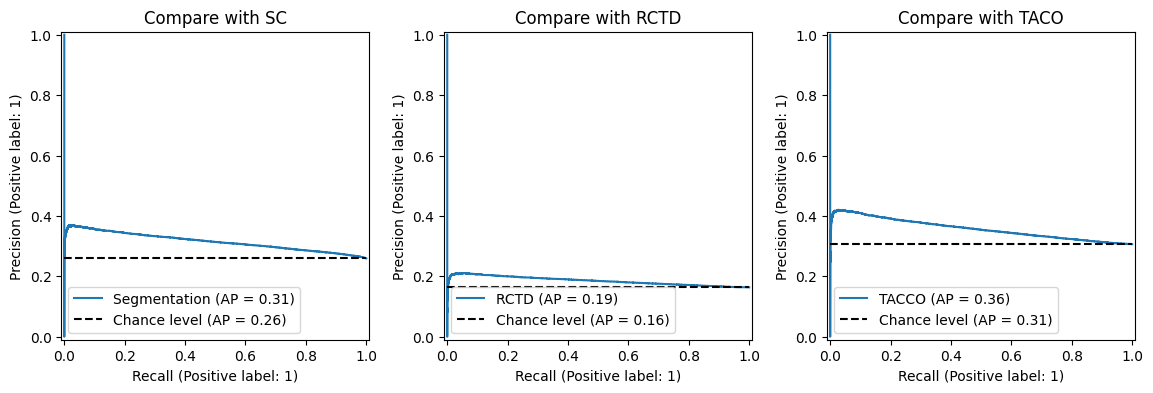

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(14,4))

display = PrecisionRecallDisplay.from_predictions(
    nn_cls == pred_cls, pred_scores, name="Segmentation", plot_chance_level=True, ax=ax[0],
)
display.ax_.set_title("Compare with SC")

display = PrecisionRecallDisplay.from_predictions(
    rctd_cls == pred_cls, pred_scores, name="RCTD", plot_chance_level=True, ax=ax[1]
)
display.ax_.set_title("Compare with RCTD")

tacco_score = np.where(np.isnan(tacco_score), 0, tacco_score)
display = PrecisionRecallDisplay.from_predictions(
    tacco_cls == pred_cls, pred_scores, name="TACCO", plot_chance_level=True, ax=ax[2]
)
display.ax_.set_title("Compare with TACCO")

### Additional visulization

In [5]:
_names = np.array(sorted(list(cell_type_dict.keys())))

cbar = np.unique(rctd_df["first_type"])

def show_cls_comparison(labels, sel, label=_names, seg=seg, cbar=cbar):
    fig, axs = plt.subplots(len(labels), len(sel), figsize=(25, 5*len(labels)))
    if axs.ndim == 1:
        axs = axs.reshape(1, -1)
    plt.subplots_adjust(left=0, right=1, top=.9, bottom=0, wspace=0, hspace=0.01)
    for row in range(len(labels)):
        for k, i in enumerate(sel):
            ax = axs[row, k]
            ax.imshow(seg[:,::-1].T, cmap='gray',  alpha=0.3)
            ax.imshow((labels[row][:, ::-1]==i+1).T, alpha=.8, cmap="gnuplot")
            ax.axis('off')
            if row == 0:
                ax.set_title(label[i], )
    return axs

def get_332_cmap(ncls):
    cmap_i = np.round((np.arange(ncls+1))/(ncls+1) * 255).astype("uint8")
    cmap_b = (cmap_i % 4)
    cmap_b[1:] += 1
    cmap_b = cmap_b/4
    cmap_g = ((cmap_i // 4) % 8) / 7
    cmap_r = (cmap_i // 32) / 7
    cmap_list = list(zip(cmap_r, cmap_g, cmap_b))
    cmap = matplotlib.colors.ListedColormap(cmap_list)
    return cmap

def show_label(labels, cls_label=_names):
    cmap = get_332_cmap(len(cls_label))
    n_imgs = len(labels)
    
    fig, ax = plt.subplots(1, n_imgs + 1, figsize=(5*n_imgs+2, 7), gridspec_kw={'width_ratios': [3]*n_imgs + [1]})

    for col in range(n_imgs):
        ax[col].imshow(labels[col][:,::-1].T, interpolation='nearest', cmap=cmap)
        ax[col].axis("off")
    
    ax[n_imgs].imshow((cbar+1)[:, None].repeat(10,axis=-1), vmin=0, interpolation='none', cmap=cmap)
    for k, name in enumerate(cls_label):
        ax[n_imgs].text(10, k+.35, name, fontsize=8)
    ax[n_imgs].axis('off')
    
    return ax

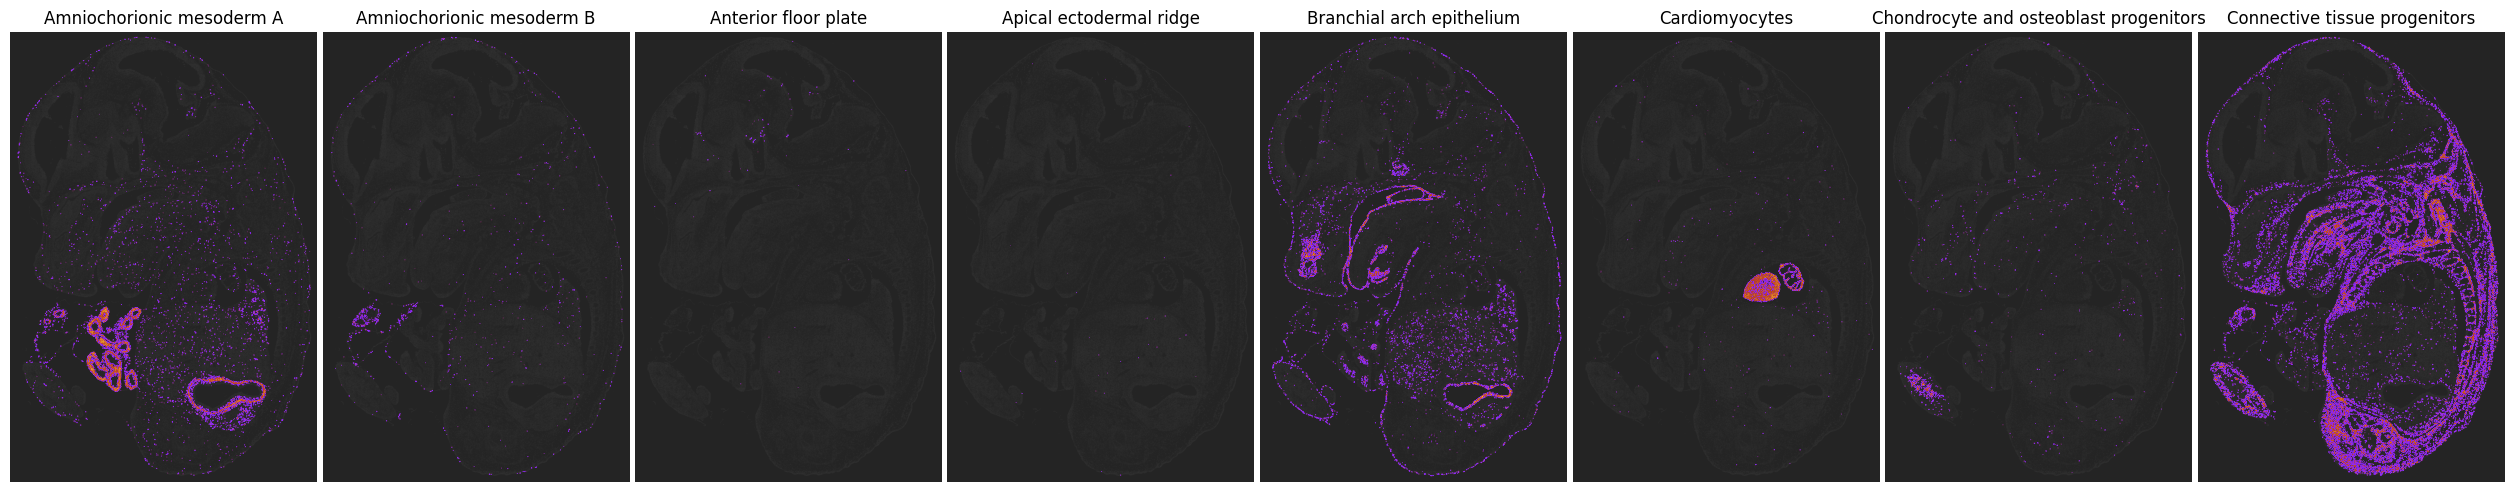

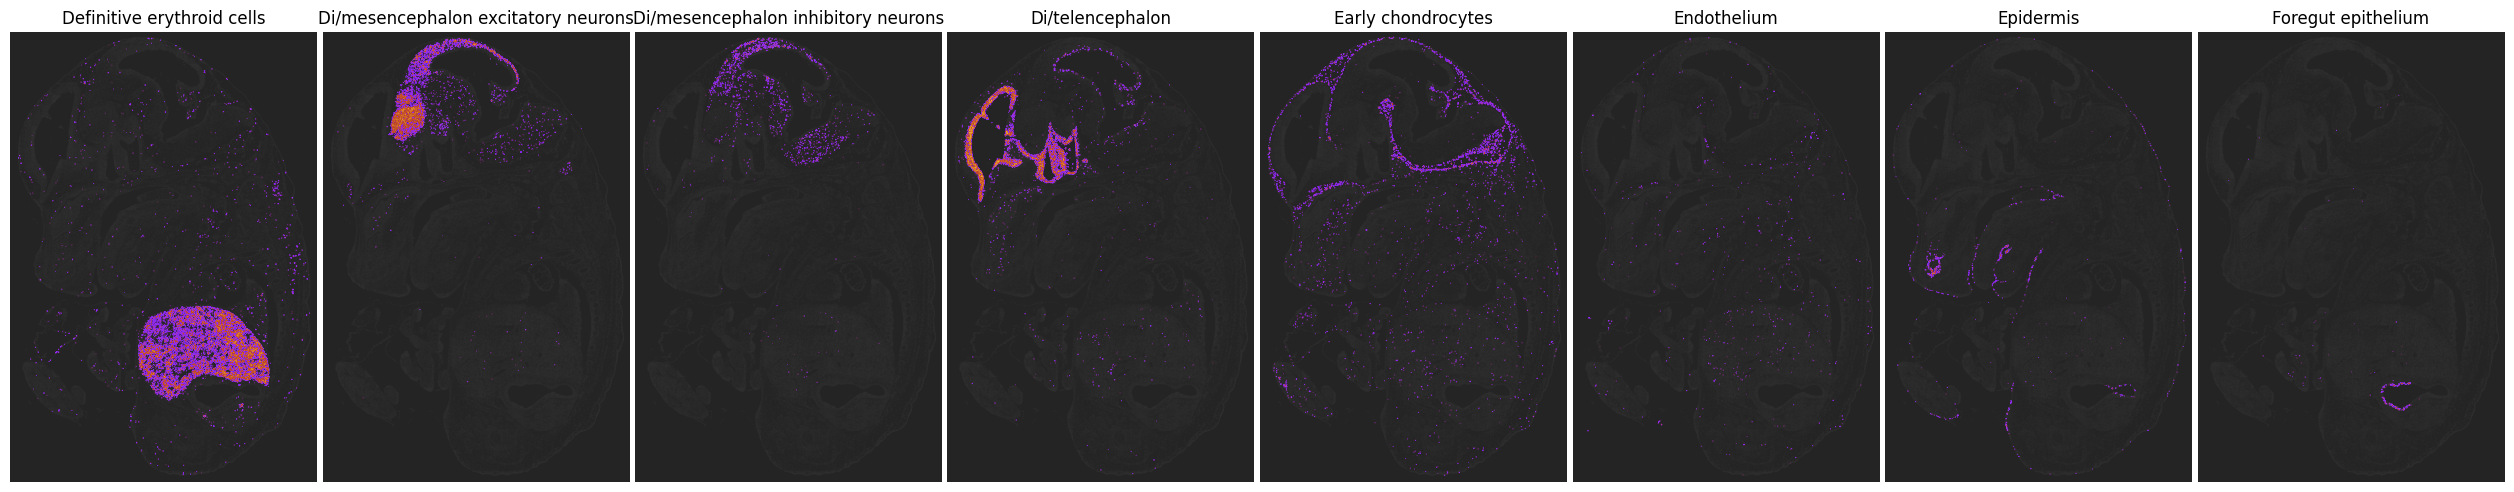

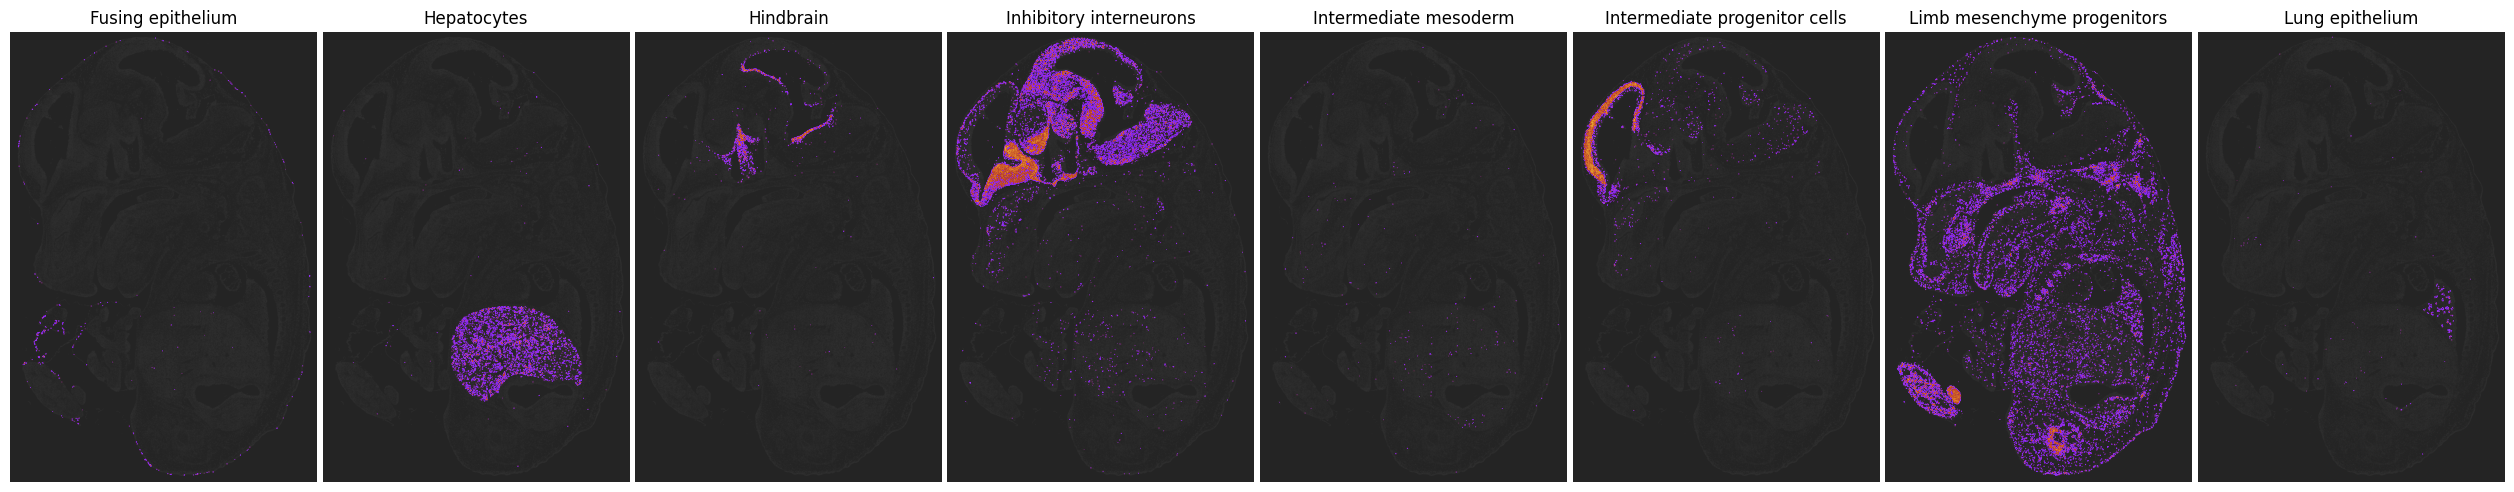

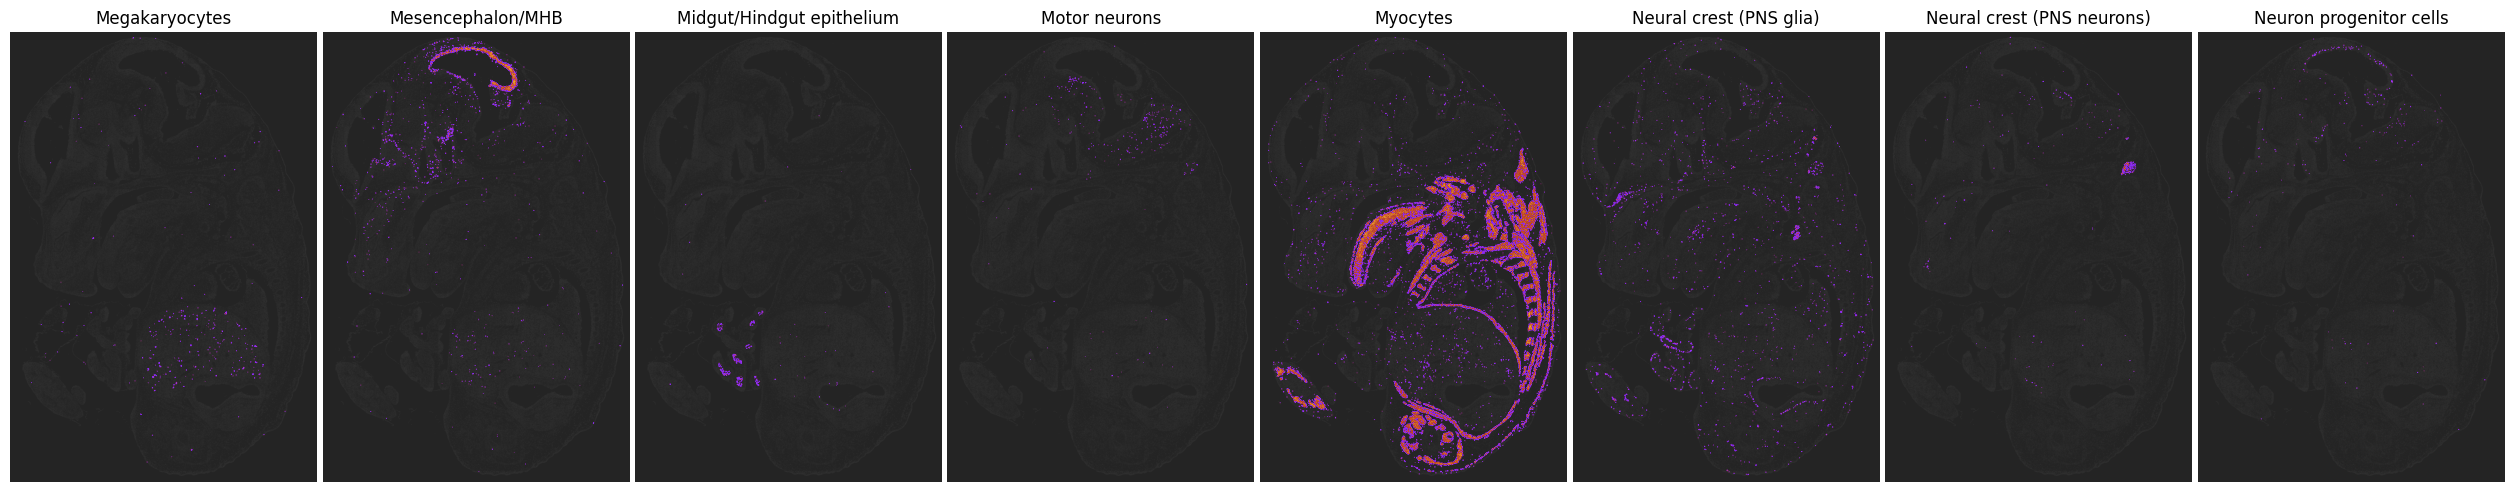

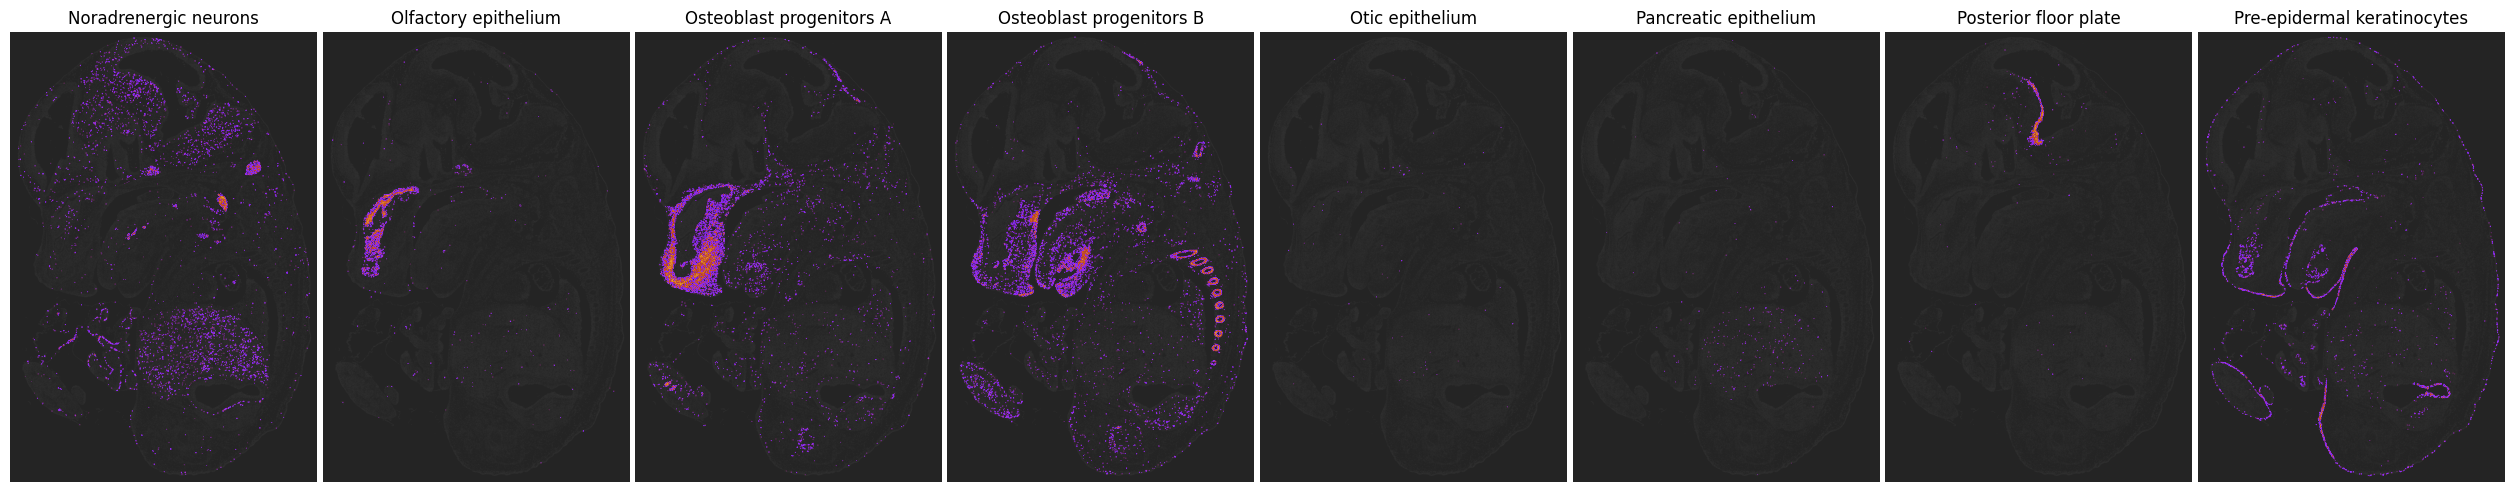

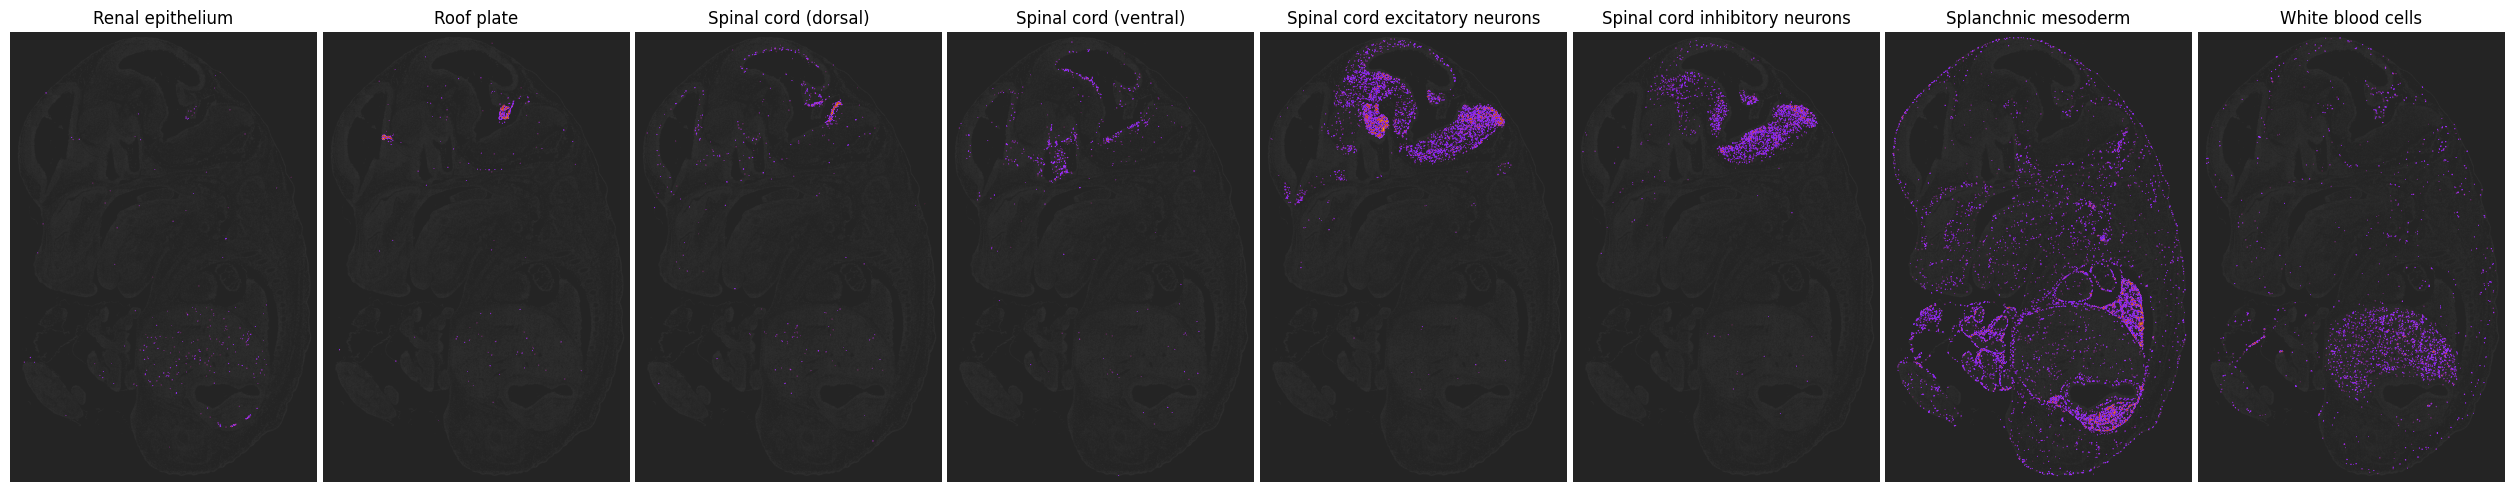

In [14]:
cbar_1 = np.array([ 0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 20, 21, 23, 24, 25, 26, 27, 28, 30, 31, 32, 34, 35, 36, 37, 38, 40, 41, 42, 44, 45, 46, 47, 50, 51, 54, 58, 62, 63, 64, 65, 66, 67])

for k in range(0, len(cbar_1), 8):
    sel = cbar_1[k:k+8]
    if len(sel) < 8:
        sel = list(sel) + [-1] * (8-len(sel))
    axs = show_cls_comparison([pred_label], sel)

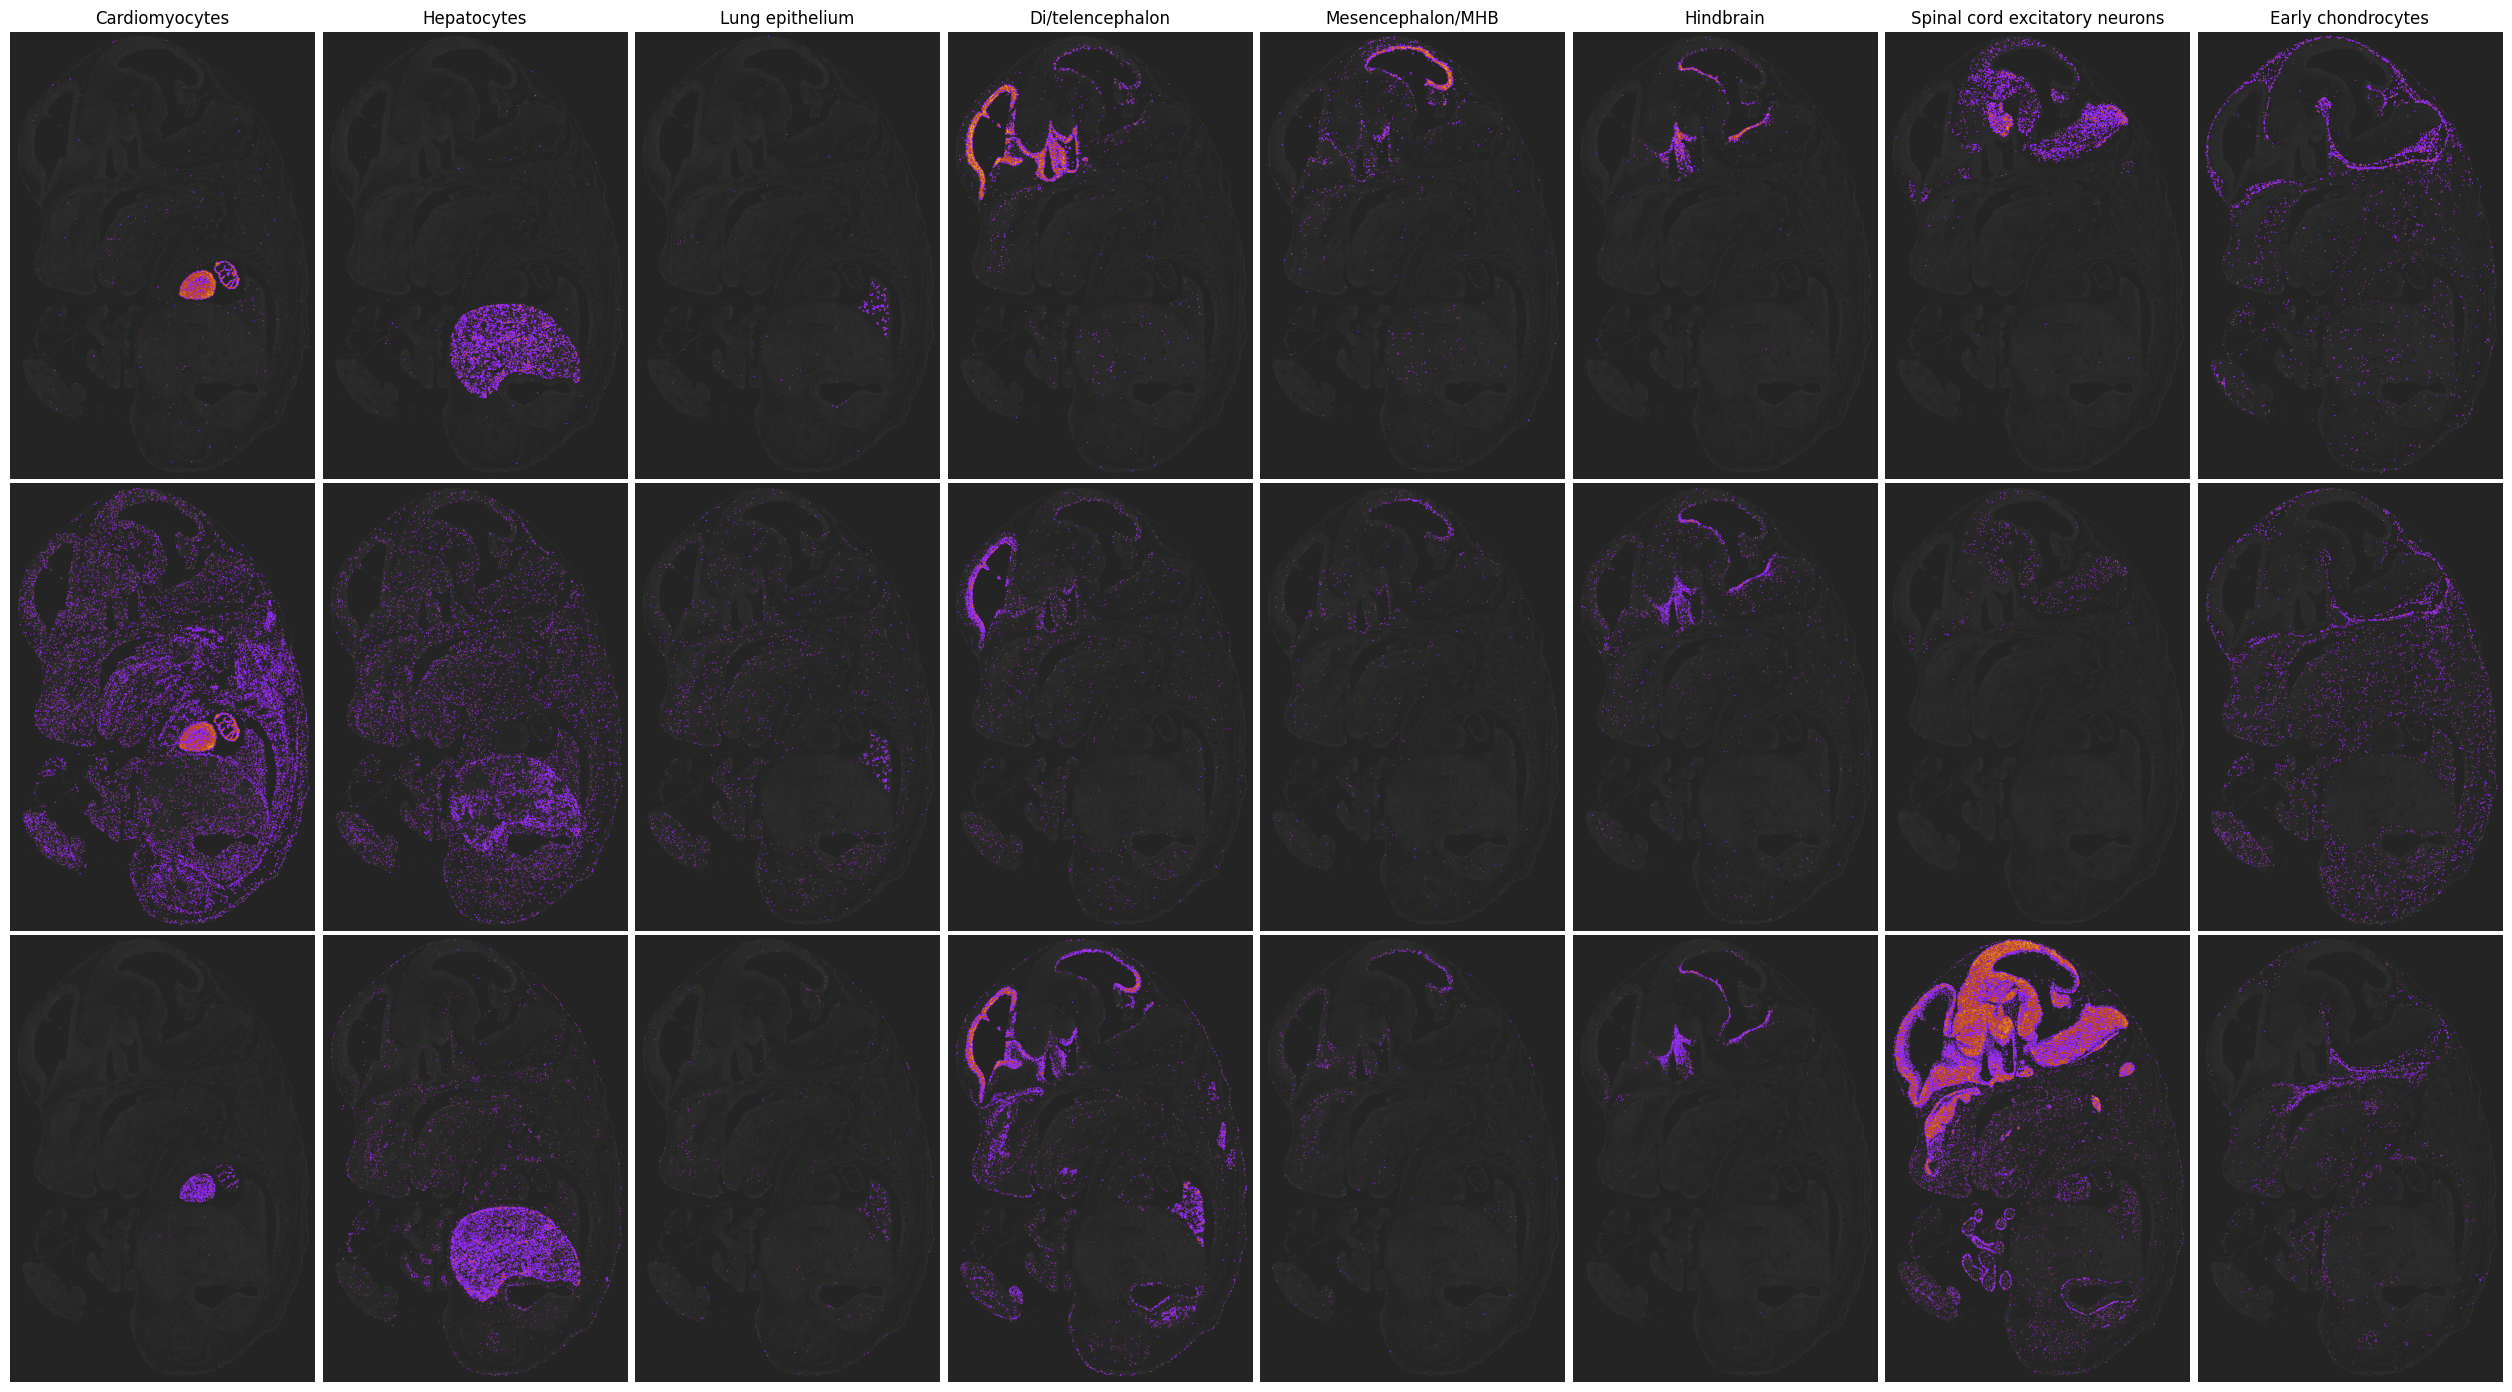

In [15]:
sel = [7, 23, 30, 13, 32, 24, 64, 14]
axs = show_cls_comparison([pred_label, rctd_label, tacco_label], sel)

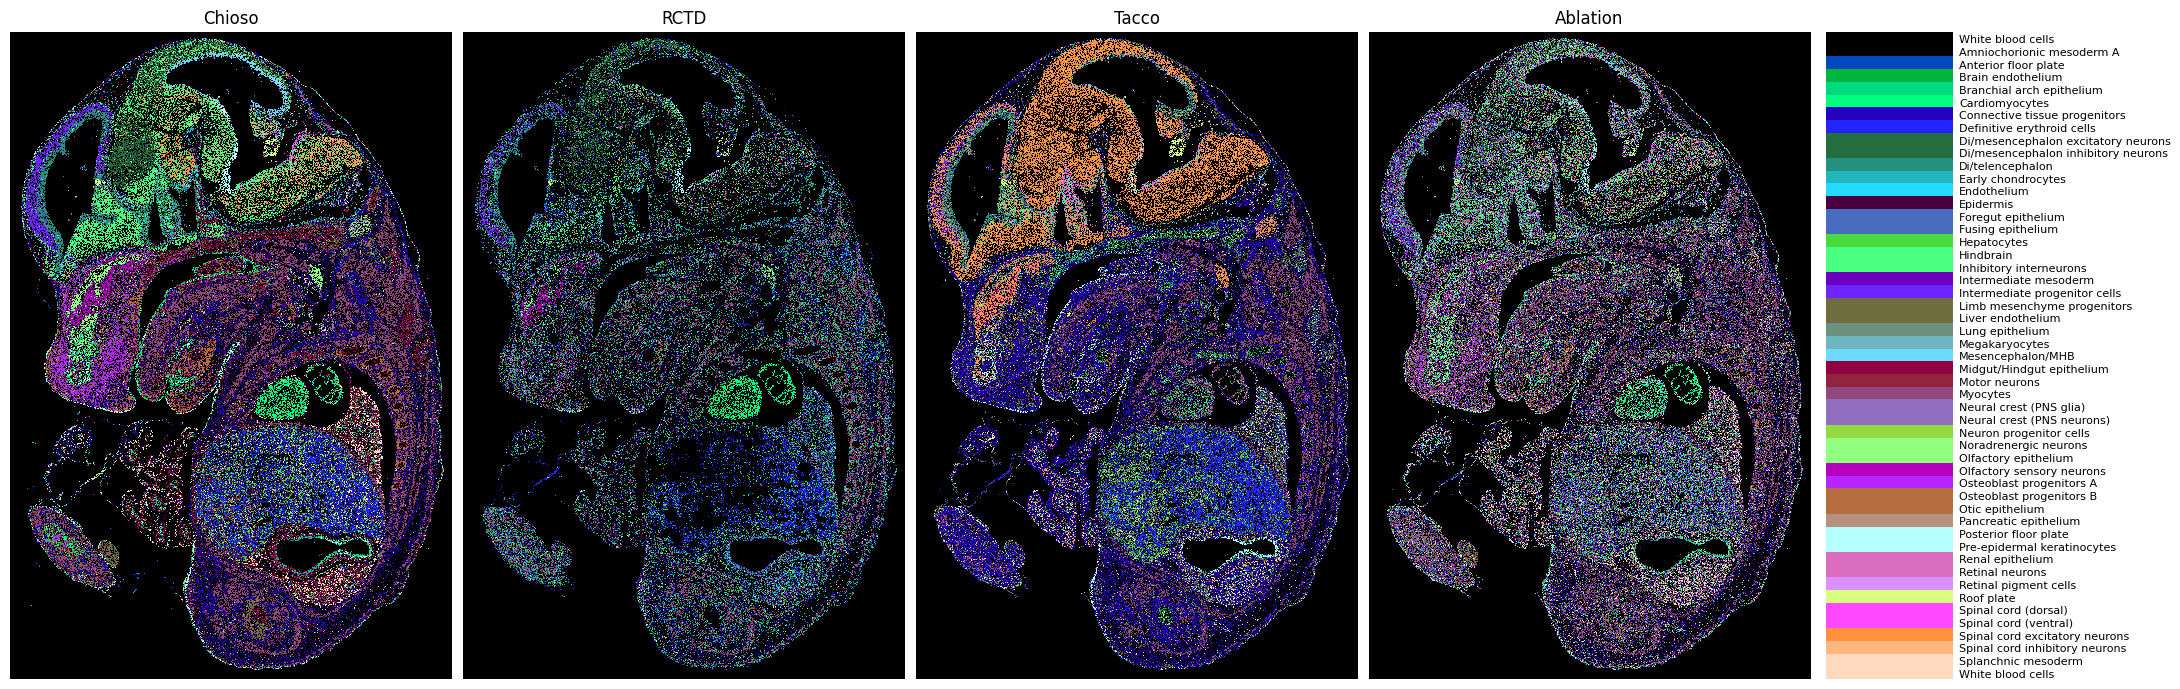

In [6]:
axs=show_label([pred_label, rctd_label, tacco_label, nn_label], np.array(sorted(list(cell_type_dict.keys())))[cbar])
axs[0].set_title("Chioso")
axs[1].set_title("RCTD")
axs[2].set_title("Tacco")
axs[3].set_title("Ablation")
plt.subplots_adjust(left=0.01)    
plt.tight_layout()

### Structure analysis

Perform outlier detection on each cell type: classifier each cell as either "normal" or "outlier" based on its location

This works well to detect wrong label if the celltype clump in a localized region (e.g. cardiomycyte), but is less useful for dispersed cells (e.g. red blood cell)

In [15]:
# compute cell centroids
sc = np.zeros([seg.max(), 2])
for rp in regionprops(seg):
    sc[rp.label-1] = rp.centroid
sc.shape

(398098, 2)

In [16]:
import pandas as pd
df0 = pd.DataFrame(dict(y=sc[:,0], x=sc[:,1], cls=pred_cls, method="chioso"))
df1 = pd.DataFrame(dict(y=sc[:,0], x=sc[:,1], cls=rctd_cls, method="rctd"))
df2 = pd.DataFrame(dict(y=sc[:,0], x=sc[:,1], cls=tacco_cls, method="tacco"))
df = pd.concat([df0, df1, df2])
df

y            x  cls  method
0       2356.000000  3077.000000   45  chioso
1       2638.588235  1550.411765   28  chioso
2        513.000000   892.000000   33  chioso
3       2992.888889  1670.222222   67  chioso
4       3353.000000  1638.500000   33  chioso
...             ...          ...  ...     ...
398093   721.111111  3819.888889   64   tacco
398094  2476.500000  1558.125000   67   tacco
398095   745.333333  2970.444444    9   tacco
398096  2988.000000  3991.000000    9   tacco
398097  1783.714286  4716.000000   64   tacco

[1194294 rows x 4 columns]

In [19]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from tqdm import tqdm

clf = IsolationForest()
df["score"] = 0.0
for t in tqdm(range(68)):
    sc_ = np.stack([df.loc[df.cls==t, "y"], df.loc[df.cls==t, "x"]], axis=-1)
    if sc_.shape[0] < 10:
        df.loc[df.cls==t, "score"] = 0.1
    else:
        clf.fit(sc_)
        df.loc[df.cls==t, "score"] = clf.decision_function(sc_)
df.score = df.score > 0.05    

100%|██████████| 68/68 [00:13<00:00,  5.13it/s]


In [20]:
dfg = df.groupby(["method", "cls", "score"]).count().drop("x", axis=1).reset_index("score")
dfg = dfg.pivot(columns="score", values="y").rename({False: "outlier", True: "detections"}, axis=1)
dfg["outlier ratio"] = dfg.outlier / (dfg.outlier + dfg.detections)
dfg = dfg.reset_index("cls")
dfg = dfg.loc[dfg.cls<=68]
lut = np.array(sorted(list(cell_type_dict.keys())))
dfg["cls"] = lut[dfg.cls]
dfg

score                              cls  outlier  detections  outlier ratio
method                                                                    
chioso       Amniochorionic mesoderm A   5474.0      8842.0       0.382369
chioso       Amniochorionic mesoderm B    586.0       455.0       0.562920
chioso            Anterior floor plate     58.0        59.0       0.495726
chioso         Apical ectodermal ridge     15.0        22.0       0.405405
chioso               Blood progenitors     91.0        71.0       0.561728
...                                ...      ...         ...            ...
tacco            Spinal cord (ventral)    397.0      1348.0       0.227507
tacco   Spinal cord excitatory neurons  38218.0     29992.0       0.560299
tacco   Spinal cord inhibitory neurons   4190.0      4343.0       0.491035
tacco              Splanchnic mesoderm   3075.0      1882.0       0.620335
tacco                White blood cells   6890.0      1478.0       0.823375

[168 rows x 4 columns]

In [21]:
dfg = dfg.loc[(dfg["cls"]==lut[7]) | (dfg["cls"]==lut[23]) |(dfg["cls"]==lut[30])  ]
dfg

score               cls  outlier  detections  outlier ratio
method                                                     
chioso   Cardiomyocytes    216.0      3992.0       0.051331
chioso      Hepatocytes    514.0      9615.0       0.050745
chioso  Lung epithelium     80.0       314.0       0.203046
rctd     Cardiomyocytes  16346.0      5125.0       0.761306
rctd        Hepatocytes   6100.0      3332.0       0.646735
rctd    Lung epithelium   1298.0       256.0       0.835264
tacco    Cardiomyocytes     31.0      1112.0       0.027122
tacco       Hepatocytes   3048.0     11981.0       0.202808
tacco   Lung epithelium    330.0       132.0       0.714286

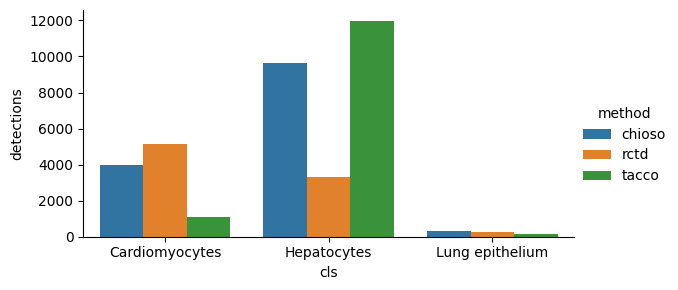

In [22]:
import seaborn as sns
sns.catplot(dfg, hue="method", x="cls", y="detections", kind="bar", height=3, aspect=2)

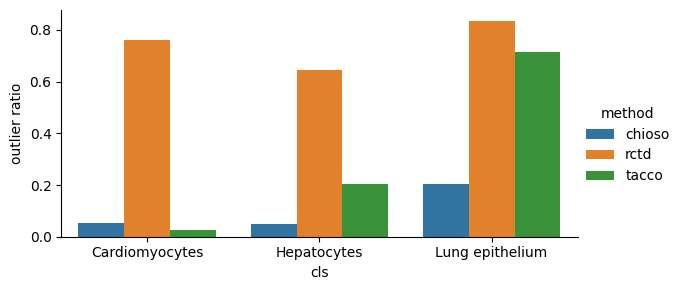

In [23]:
sns.catplot(dfg, hue="method", x="cls", y="outlier ratio", kind="bar", height=3, aspect=2)